<a href="https://colab.research.google.com/github/rosagrandio/GOOGLE_CLOUD_DEPLOYMENT/blob/master/MLOPS_GCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLOPS CON GOOGLE CLOUD PLATFORM


Tipos de deployment

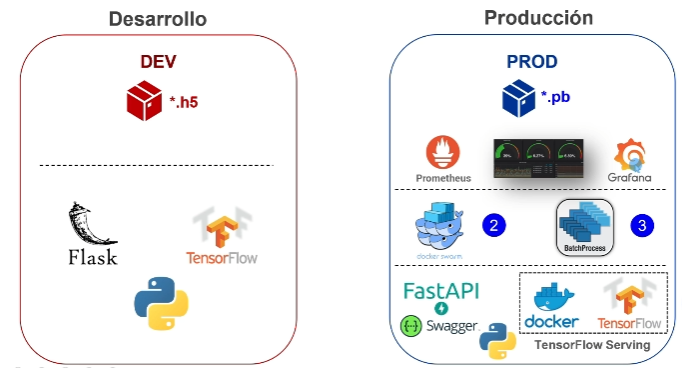

CONFIGURAR CENTOS


In [ ]:
# EN SSH
###################### CentOS Configuration ##########################
#Install tools on CentOS 7:
sudo yum –y update
sudo yum install -y zip unzip nano git tree wget

#Install an environment manager (Miniconda):
curl -LO https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
sh ./Miniconda3-latest-Linux-x86_64.sh

#Loading environment variables:
source ~/.bashrc

#Deactivate current environment (base):
conda deactivate
######################################################################

## 1. GUARDAR EL MODELO ENTRENADO

In [ ]:
# Saving as Keras model in 2 separate files:

# 1. Model configuration (json file)
cnn_model_json = model.to_json()
with open(project_folder + "/model/tf2x/keras/split/pantera.json","w") as json_file:
  json_file.write(cnn_model_json)

# 2. Model weights (h5 file)
model.save_weights(project_folder + "/model/tf2x/keras/split/pantera.h5")
print("Modelo guardado en disco ...")

Modelo guardado en disco ...


In [ ]:
# Saving full model in a single file:

# Keras format
model.save(project_folder + "/model/tf2x/keras/full/pantera_full_tf2.h5", save_format='h5')

# TF2.0 format
version_model="1"
model.save(project_folder + "/model/tf2x/tensorflow/" + version_model + "/", save_format='tf')

GUARDAR MODELOS EN EL SSH DE CENTOS

In [ ]:
############# Download Deep Learning models (model.zip) ##############
#Create folder "~/models" to download deep learning models:
mkdir -p ~/models
cd ~/models

#Download models from google drive
export FILEID=1nTvxUq9QYAZTv_v6-XIyRj4avcOchBtw
wget --load-cookies cookies.txt \
    "https://docs.google.com/uc?export=download&confirm=$(wget \
    --quiet \
    --save-cookies cookies.txt \
    --keep-session-cookies \
    --no-check-certificate 'https://docs.google.com/uc?export=download&id='${FILEID} \
    -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=${FILEID}" \
    -O model.zip && rm -rf cookies.txt

unzip model.zip && rm -rf model.zip && cd ~

#List downloaded models
tree ~/models
######################################################################

## 2. ENTORNO DEPLOYMENT DESARROLLO DEV

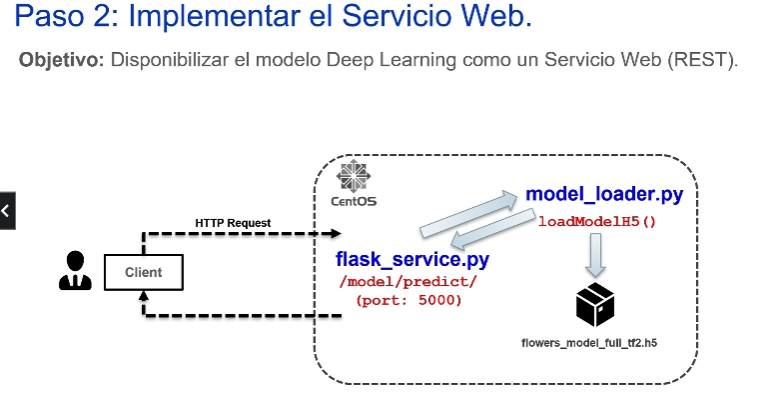

 CONFIGURAR CENTOS EN GOOGLE CLOUD: 
* Abrir http
* abrir puerto 5000

* Descargar scripts de py de desarrollo. Hacerlo con SSH de CENTOS en el DEV

In [ ]:
########################## Deployment DEV EN SSH DE GOOGLE CLOUD DE CENTOS #########################
#Clone main deployment project:
cd ~
git clone https://github.com/mirkorodriguez/DEEP-LEARNING_deployment.git

#Locate on service folder:
cd ~/DEEP-LEARNING_deployment/Deployment-DEV/service/

#Activate DEV environment:
conda activate DEV

#Starting web service on port 5000:
python flask_service.py --port 5000

#Starting web service on port 5000 (daemon):
#python flask_service.py --port 5000 &
###################################################################

#Stop Web service: Ctrl + C

#Deactivate DEV env
conda deactivate

flask_service llama a model_load
El centos se abre al cliente por el puerto 5000

### CREAR CLIENTE

Desde github abro cliente y listo

## 3. ENTORNO DEPLOYMENT DE PRODUCCIÓN

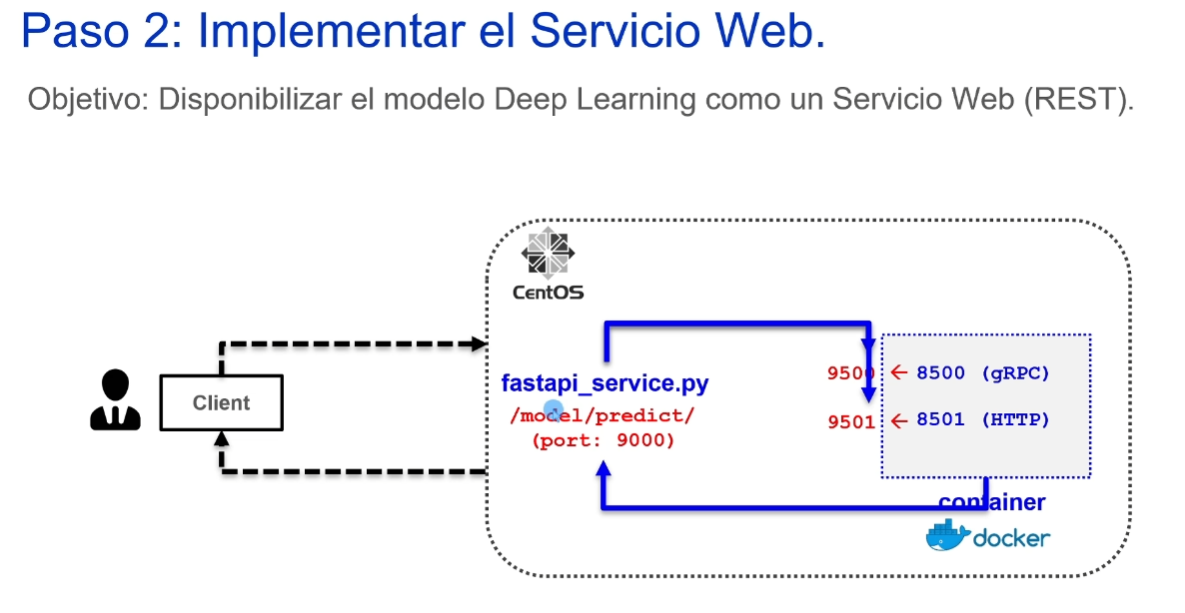

In [ ]:
## EN SSH DE CENTOS


######################### Create PROD Environment ####################
#Create an environment called "PROD" and install Python
conda create -n PROD pip python=3.7.0

#Activate PROD Environment
conda activate PROD

#Install python
pip install python=3.7.5

#Install TensorFlow in PROD:
pip install --no-cache-dir tensorflow==2.3.0
pip install tensorflow-serving-api

#Install FastAPI, uvicorn and other tools in PROD:
pip install fastapi
pip install uvicorn # ASGI server for production: https://github.com/tiangolo/fastapi
pip install python-multipart
pip install pillow #Pil image needed for tf.keras image

#Testing tools installation version:
python -c "import platform; print('\nPython: ',platform.python_version())"
python -c "import tensorflow as tf; print('TensorFlow: ',tf.__version__)"
python -c "import fastapi; print('FastAPI: ', fastapi.__version__)"

#Deactiavate current environment:
conda deactivate
#########################################################################

In [ ]:
######################## Deployment PROD ver1 ########################
#Initializing TensorFlow serving with .pb model
cd ~
export MODEL_PB=$(pwd)/models/tf2x/tensorflow

#Start docker service:
sudo systemctl start docker

#Start TensorFlow serving with our model:
docker run \
    -p 9500:8500 \
    -p 9501:8501 \
    -v "$MODEL_PB:/models/flowers" \
    -e MODEL_NAME=flowers \
    -t tensorflow/serving &

#Validate container
docker ps
curl http://127.0.0.1:9501/v1/models/flowers

#Activate PROD environment
conda activate PROD

#Locate on test folder
cd ~/DEEP-LEARNING_deployment/Deployment-PROD1/test

#TFserving on HTTP 9501 --> 8501
python test-tfserving-http.py \
    --image $(pwd)/images/img01.jpg \
    --model flowers \
    --version 1 \
    --port 9501

#TFserving on gGPR 9500 --> 8500
python test-tfserving-gRPC.py \
    --image $(pwd)/images/img01.jpg \
    --model flowers \
    --version 1 \
    --port 9500

#Stop docker container
#docker stop <CONTAINER-ID>

#Stop docker service
#sudo systemctl stop docker
###################################################################################

############################### Start FastAPI service  ############################
# Starting the service
cd ~/DEEP-LEARNING_deployment/Deployment-PROD1/service/

# Activating PROD env
conda activate PROD

# starting web-service
uvicorn fastapi_service:app --port 9000 --host 0.0.0.0

# starting web-service (for development only)
uvicorn fastapi_service:app --port 9000 --host 0.0.0.0 --reload  #reload changes
###################################################################################

#Swagger (connect to path /docs)
#http://127.0.0.1:9000/docs

#ReDoc (connect to path /redoc)
#http://127.0.0.1:9000/redoc

#Stop Web Service: Ctrl + C

#Deactivate PROD env
conda deactivate



# ---------------------------------------------------------------------------------

# WORKING WITH docker compose (alternative)
################################# Install docker Compose ##########################
#Install docker-compose:
sudo curl -L "https://github.com/docker/compose/releases/download/1.23.2/docker-compose-$(uname -s)-$(uname -m)" -o /usr/local/bin/docker-compose

#Permissions for execution mode:
sudo chmod +x /usr/local/bin/docker-compose

#Validate docker-compose version:
docker-compose --version
###################################################################################





#################### Start TensorFlow service with docker-compose #################
#Start docker service:
sudo systemctl start docker

#Delete all Containers:
docker stop $(docker ps -aq)
docker rm $(docker ps -aq)
docker ps -a

#Folder with PB model
cd ~
export MODEL_PB=$(pwd)/models/tf2x/tensorflow

#Start TensorFlow serving with docker-compose:
cd ~/DEEP-LEARNING_deployment/Deployment-PROD1/docker

#Docker UP
docker-compose -f compose-config.yml up &

#Docker DOWN
docker-compose -f compose-config.yml down
###################################################################################

Desde github abro cliente y listo


## CERRAR CENTOS
